In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 1: Importing Recording Data and Metadata

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import imp
import git
import itertools
import cupy as cp

/tmp/ipykernel_36058/2470856654.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"

In [4]:
os.environ["CUDA_PATH"] = "/usr/local/cuda-11.7"

In [5]:
from collections import defaultdict
import time
import json

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal
from labellines import labelLine, labelLines


In [7]:
from spectral_connectivity import Multitaper, Connectivity

In [8]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [9]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [10]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [11]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [12]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [13]:
import spikeinterface.full as si

In [14]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

- Getting the root directory of the Github Repo to base the files off of

In [15]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [16]:
git_root

'/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls'

- Getting a list of all the electrophysiological recording files
    - **NOTE**: If your recording file does not end with `.rec` or is in a different directory than `./data` then you must change `glob.glob({./path/to/recording_file.rec})` below. Where you replace `{./path/to/recording_file.rec}` with the path to your recording file without the brackets.

```
MD EIB: 0(1 on Nancy notebook) Spike Gadgets/Spike Interface: 0
vHPC EIB: 16(17 on Nancy notebook) Spike Gadgets/Spike Interface: 31
BLA EIB: 17(18 on Nancy notebook) Spike Gadgets/Spike Interface: 30
LH EIB: 18(19 on Nancy notebook) Spike Gadgets/Spike Interface: 29
```

In [17]:
brain_region_to_channel = {"mPFC": "21", "MD": "16", "vHPC": "15", "BLA": "14", "LH": "13"}

In [18]:
channel_brain_region = {v: k for k, v in brain_region_to_channel.items()}

In [19]:
channel_brain_region

{'21': 'mPFC', '16': 'MD', '15': 'vHPC', '14': 'BLA', '13': 'LH'}

In [20]:
brain_region_to_channel = {k: v for k, v in sorted(brain_region_to_channel.items(), key=lambda item: item[1])}

In [21]:
brain_region_to_channel.keys()

dict_keys(['LH', 'BLA', 'vHPC', 'MD', 'mPFC'])

In [22]:
brain_region_to_channel.values()

dict_values(['13', '14', '15', '16', '21'])

In [23]:
brain_region_to_channel

{'LH': '13', 'BLA': '14', 'vHPC': '15', 'MD': '16', 'mPFC': '21'}

In [24]:
all_channels = [int(ch) for ch in brain_region_to_channel.values()]

In [25]:
all_channels

[13, 14, 15, 16, 21]

In [26]:
all_regions = brain_region_to_channel.keys()

In [27]:
all_regions

dict_keys(['LH', 'BLA', 'vHPC', 'MD', 'mPFC'])

In [28]:
resampled_frequency = 1000

## Calculating the power

In [29]:
lfp_array_filepath_glob = glob.glob("./proc/*/*traces.npy", recursive=True)

In [30]:
lfp_array_filepath_glob = [file for file in lfp_array_filepath_glob if "and" not in file]

In [31]:
lfp_array_filepath_glob

['./proc/20221122_164720_competition_6_1_top_3__base_3_merged/20221122_164720_competition_6_1_top_3__base_3_merged.traces.npy',
 './proc/20221122_161341_omission_subject_6_1_top_4_base_2/20221122_161341_omission_subject_6_1_top_4_base_2.traces.npy',
 './proc/20221125_144832_omission_subject_6_1_top_1_base_2_merged/20221125_144832_omission_subject_6_1_top_1_base_2_merged.traces.npy',
 './proc/20221125_152723_competition_subject_6_1_top_3_base_2_merged/20221125_152723_competition_subject_6_1_top_3_base_2_merged.traces.npy']

In [39]:
time_halfbandwidth_product = 30
blocks = 5

In [40]:
time_window_duration = 2

In [41]:
time_window_step = time_window_duration * 0.5

In [42]:
first_proportion = 0
second_proportion = 1

- Individual channels

In [36]:
with cp.cuda.Device(0):
    power_issue_files = []
    for lfp_filepath, channel in itertools.product(lfp_array_filepath_glob, all_channels):
        print("LFP File Path: {}".format(lfp_filepath)) 
        print("Channel: {}".format(channel))
        try:
            recording_basename = os.path.basename(os.path.dirname(lfp_filepath))
            parent_output_directory = os.path.dirname(lfp_filepath)

            # Loading in LFP array
            lfp_array = np.load(lfp_filepath)
            # Cutting the LFP array to reduce on the memory usage
            lfp_array = lfp_array[int(lfp_array.shape[0]*first_proportion):int(lfp_array.shape[0]*second_proportion), channel]
            print(lfp_array.shape)
            print("calculating multitaper")
            # Compute multitaper spectral estimate
            m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=lfp_array, \
                           sampling_frequency=resampled_frequency, time_window_duration=time_window_duration, \
                           time_window_step=time_window_step)

            print("calculating connectivity")
            # Sets up computing connectivity measures/power from multitaper spectral estimate
            c = Connectivity.from_multitaper(m, blocks=blocks)

            # Saving to file
            frequencies_filename = "{}_thp_{}_twd_{}_ch_{}.frequencies.npy".format(recording_basename, time_halfbandwidth_product, time_window_duration, channel)
            power_filename = "{}_thp_{}_twd_{}_ch_{}.power.npy".format(recording_basename, time_halfbandwidth_product, time_window_duration, channel)
            
            np.save(file=os.path.join(parent_output_directory, frequencies_filename), arr=c.frequencies)
            np.save(file=os.path.join(parent_output_directory, power_filename), arr=c.power().squeeze())

        except Exception as e: 
            print(e)
            power_issue_files.append((lfp_filepath, channel))

LFP File Path: ./proc/20221122_164720_competition_6_1_top_3__base_3_merged/20221122_164720_competition_6_1_top_3__base_3_merged.traces.npy
Channel: 13
(1599198,)
calculating multitaper
calculating connectivity
LFP File Path: ./proc/20221122_164720_competition_6_1_top_3__base_3_merged/20221122_164720_competition_6_1_top_3__base_3_merged.traces.npy
Channel: 14
(1599198,)
calculating multitaper
calculating connectivity
LFP File Path: ./proc/20221122_164720_competition_6_1_top_3__base_3_merged/20221122_164720_competition_6_1_top_3__base_3_merged.traces.npy
Channel: 15
(1599198,)
calculating multitaper
calculating connectivity
LFP File Path: ./proc/20221122_164720_competition_6_1_top_3__base_3_merged/20221122_164720_competition_6_1_top_3__base_3_merged.traces.npy
Channel: 16
(1599198,)
calculating multitaper
calculating connectivity
LFP File Path: ./proc/20221122_164720_competition_6_1_top_3__base_3_merged/20221122_164720_competition_6_1_top_3__base_3_merged.traces.npy
Channel: 21
(1599198,

- All channels

- Original Code

## Plotting to look

In [37]:
all_prefixes = ["20221122_164720_competition", "20221122_161341_omission", "20221125_144832_omission", "20221125_152723_competition"]

13
14
15
16
21
20221122_164720_competition_6_1_top_3__base_3_merged_thp_10_twd_120.png


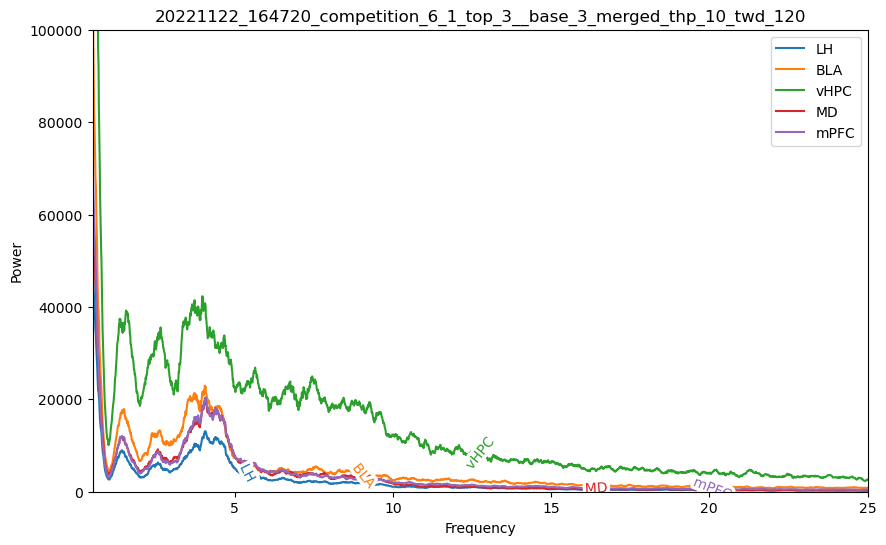

13
14
15
16
21
20221122_161341_omission_subject_6_1_top_4_base_2_thp_10_twd_120.png


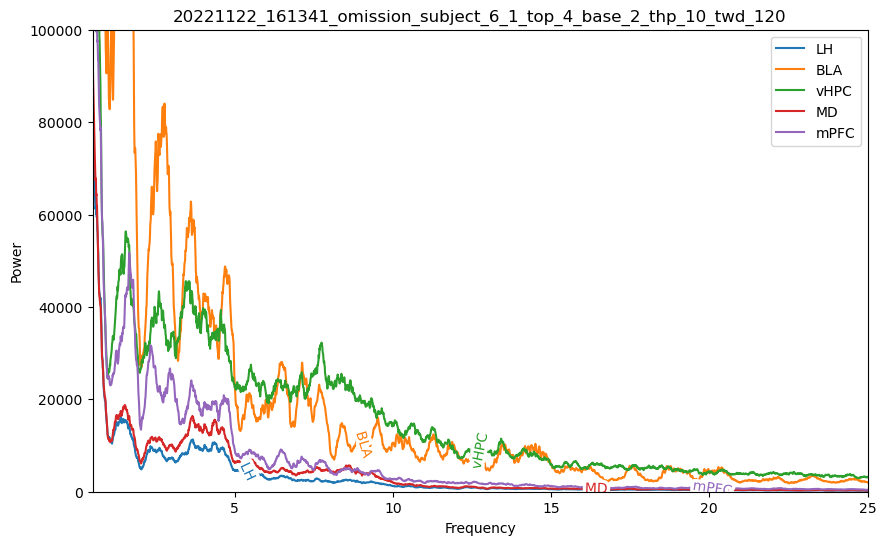

13
14
15
16
21
20221125_144832_omission_subject_6_1_top_1_base_2_merged_thp_10_twd_120.png


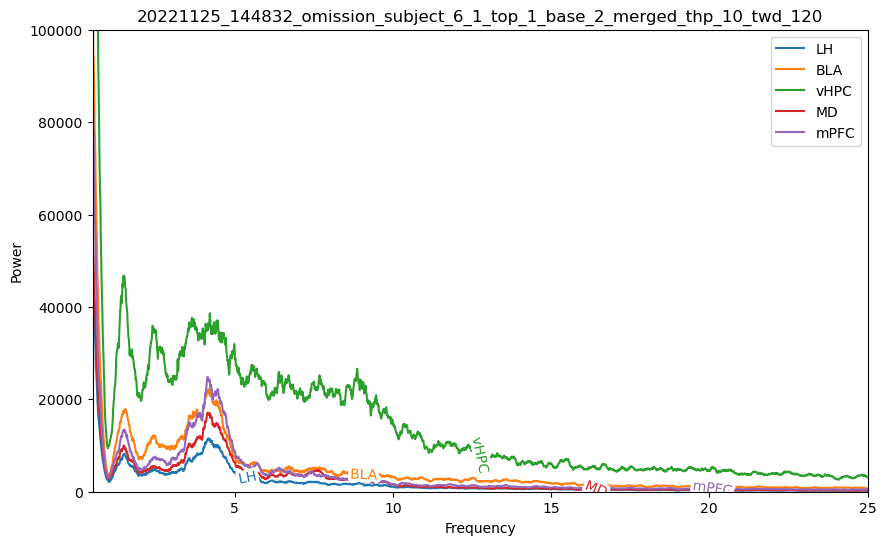

13
14
15
16
21
20221125_152723_competition_subject_6_1_top_3_base_2_merged_thp_10_twd_120.png


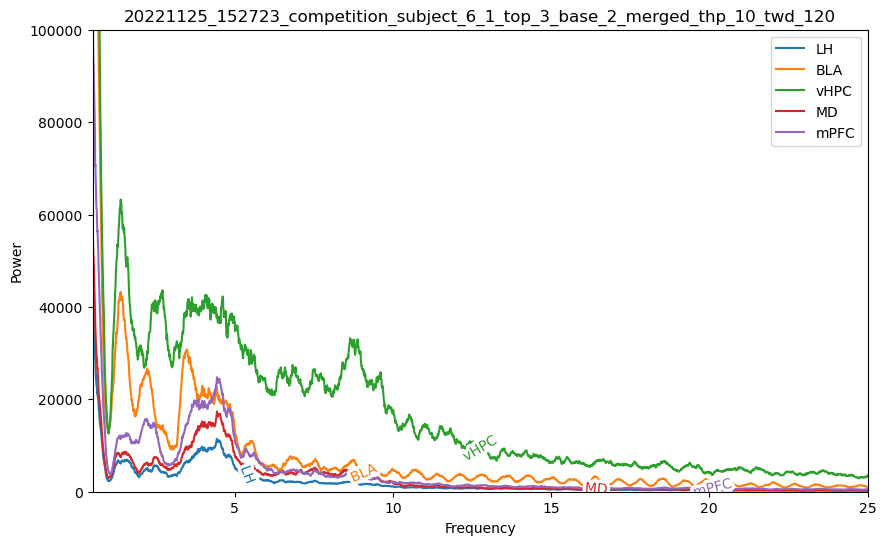

In [38]:
for prefix in all_prefixes:
    freq_array_filepath_glob = sorted(glob.glob("./proc/*/*{}*thp_{}*twd_{}*frequencies.npy".format(prefix, time_halfbandwidth_product, time_window_duration), recursive=True))
    power_array_filepath_glob = sorted(glob.glob("./proc/*/*{}*thp_{}*twd_{}*power.npy".format(prefix, time_halfbandwidth_product, time_window_duration), recursive=True))
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for freq_array_path, power_array_path in zip(freq_array_filepath_glob, power_array_filepath_glob):
        output_dir_path = os.path.dirname(freq_array_path)
        channel = freq_array_path.split("ch_")[1].split(".")[0]
        print(channel)
        freq_array = np.load(freq_array_path)
        power_array = np.load(power_array_path)


        ax.plot(freq_array, np.mean(power_array, axis=0), label=channel_brain_region[channel])


    freq_start = 0.5
    freq_end = 12
    freq_end = 25
    ax.set_xlim(freq_start, freq_end)
    ax.set_ylim(0,100000)
    ax.legend()
    labelLines(ax.get_lines(), zorder=2.5)   

    lfp_basename = os.path.basename(freq_array_path).split(".")[0]
    lfp_basename = lfp_basename.split("_ch")[0]

    plt.title("{}".format(lfp_basename))
    plt_file_name = "{}.png".format(lfp_basename)
    print(plt_file_name)
    plt.savefig(os.path.join(output_dir_path, plt_file_name))
    plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for freq_array_path, power_array_path in zip(freq_array_filepath_glob, power_array_filepath_glob):
    output_dir_path = os.path.dirname(freq_array_path)
    channel = freq_array_path.split("ch_")[1].split(".")[0]
    print(channel)
    freq_array = np.load(freq_array_path)
    power_array = np.load(power_array_path)
    

    ax.plot(freq_array, np.mean(power_array, axis=0), label=channel_brain_region[channel])
    

freq_start = 0.5
freq_end = 12
freq_end = 25
ax.set_xlim(freq_start, freq_end)
ax.set_ylim(0,100000)
ax.legend()
labelLines(ax.get_lines(), zorder=2.5)   

lfp_basename = os.path.basename(freq_array_path).split(".")[0]
lfp_basename = lfp_basename.split("_ch")[0]

plt.title("{}".format(lfp_basename))
plt_file_name = "{}.png".format(lfp_basename)
# plt.savefig(os.path.join(output_dir_path, plt_file_name))
plt.show()

In [ ]:
raise ValueError()

- One at a time

In [ ]:
freq_array_filepath_glob = sorted(glob.glob("./proc/*/*thp_{}*twd_{}*frequencies.npy".format(time_halfbandwidth_product, time_window_duration), recursive=True))
power_array_filepath_glob = sorted(glob.glob("./proc/*/*thp_{}*twd_{}*power.npy".format(time_halfbandwidth_product, time_window_duration), recursive=True))

In [ ]:
freq_array_filepath_glob

In [ ]:
power_array_filepath_glob

- All channels

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for freq_array_path, power_array_path in zip(freq_array_filepath_glob, power_array_filepath_glob):
    output_dir_path = os.path.dirname(freq_array_path)
    channel = freq_array_path.split("ch_")[1].split(".")[0]
    print(channel)
    freq_array = np.load(freq_array_path)
    power_array = np.load(power_array_path)
    

    ax.plot(freq_array, np.mean(power_array, axis=0), label=channel_brain_region[channel])
    

freq_start = 0.5
freq_end = 12
freq_end = 25
ax.set_xlim(freq_start, freq_end)
ax.set_ylim(0,100000)
ax.legend()
labelLines(ax.get_lines(), zorder=2.5)   

lfp_basename = os.path.basename(freq_array_path).split(".")[0]
lfp_basename = lfp_basename.split("_ch")[0]

plt.title("{}".format(lfp_basename))
plt_file_name = "{}.png".format(lfp_basename)
plt.savefig(os.path.join(output_dir_path, plt_file_name))
plt.show()

- Inidividual Plots